# Exemplos de uso

### Código de uma rede neural para a função XOR

Vamos criar uma rede simples com uma camada oculta, que resolve a função XOR. A função XOR é um problema linearmente inseparável, daí a necessidade de uma camada oculta. 

O código-fonte permitirá modificar facilmente o número de camadas e o número de neurônios por camada, para podermos experimentar vários cenários diferentes. Não usaremos nenhuma biblioteca ML. Em vez disso, vamos implementá-los do zero apenas com a ajuda de numpy. Também usaremos o matplotlib para visualizar os resultados.

***Importando biblioteca numpy e matplotlib***

In [1]:
import numpy
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

***Definição da função tanh***

Em seguida, vamos definir nossa função de ativação e sua derivada (usaremos a função tanh(x) neste exemplo):

In [2]:
def tanh(x):
    return (1.0 - numpy.exp(-2*x))/(1.0 + numpy.exp(-2*x))

def tanh_derivative(x):
    return (1 + x)*(1 - x)

***Classe de uma Rede Neural***

Em seguida, iniciamos a definição da classe NeuralNetwork: class NeuralNetwork: 

In [3]:
"""
Definimos o inicializador __init__ da NeuralNetwork: net_arch é uma matriz unidimensional que contém o número de 
neurônios para cada camada. Por exemplo [2, 4 e 1] significa uma camada de entrada com dois neurônios, uma camada 
oculta com quatro neurônios e uma camada de saída com um neurônio. Como estamos estudando a função XOR, a camada 
de entrada terá dois neurônios e a camada de saída terá apenas um neurônio. 

Também definimos a função de ativação como tangente hiperbólica e, em seguida, definiremos sua derivada. 

Por fim, inicializamos os pesos da rede com valores aleatórios no intervalo (-1, 1), conforme demonstrado no seguinte 
bloco de código: # net_arch consiste em uma lista de números inteiros, indicando o número de neurônios em cada camada.
"""

class NeuralNetwork:
    # net_arch consiste em uma lista de números inteiros, indicando 
    # o número de neurônios em cada camada
    def __init__(self, net_arch):
        self.activation_func = tanh
        self.activation_derivative = tanh_derivative
        self.layers = len(net_arch)
        self.steps_per_epoch = 1000
        self.net_arch = net_arch

        # inicialize os pesos com valores aleatórios no intervalo (-1,1)
        self.weights = []
        for layer in range(len(net_arch) - 1):
            w = 2 * numpy.random.rand(net_arch[layer] + 1, net_arch[layer + 1]) - 1
            self.weights.append(w)

            
    """
    Precisamos definir a função de ajuste, que treinará nossa rede. 

    Primeiro, adicionamos 1 aos dados de entrada (o neurônio de viés sempre ativo) e configuramos o código para imprimir 
    o resultado no final de cada época para acompanhar o progresso. 

    Na última linha, nn representa a classe NeuralNetwork e prever é a função na classe NeuralNetwork que definiremos 
    mais adiante.

    Selecionamos uma amostra aleatória do conjunto de treinamento e a propagamos pela rede, para que possamos calcular 
    o erro entre a saída da rede e os dados de destino: sample = numpy.random.randint (data.shape [0])

    Agora que temos o erro, podemos propagá-lo para trás, para atualizar os pesos. Usaremos a descida do gradiente 
    estocástico para atualizar os pesos (ou seja, vamos atualizar os pesos após cada etapa)
    """
    def fit(self, data, labels, learning_rate=0.1, epochs=10):
        """
        : param data: data é o conjunto de todos os pares possíveis de booleanos
                      Verdadeiro ou Falso indicado pelos números inteiros 1 ou 0
                      labels é o resultado da operação lógica 'xor'
                      em cada um desses pares de entrada
        : param labels: array de 0/1 para cada dado

        """

        # Adicione bias de polarização à camada de entrada
        ones = numpy.ones((1, data.shape[0]))
        Z = numpy.concatenate((ones.T, data), axis=1)
        training = epochs * self.steps_per_epoch
        for k in range(training):
            """
            if k % self.steps_per_epoch == 0:
                for s in data:
                    print(s, nn.predict(s))
            """
            sample = numpy.random.randint(data.shape[0])
            y = [Z[sample]]

            for i in range(len(self.weights) - 1):
                activation = numpy.dot(y[i], self.weights[i])
                activation_f = self.activation_func(activation)
                # Adicione o bias para cada proxima camada
                activation_f = numpy.concatenate((numpy.ones(1), numpy.array(activation_f)))
                y.append(activation_f)

            # Ultima Camada
            activation = numpy.dot(y[-1], self.weights[-1])
            activation_f = self.activation_func(activation)
            y.append(activation_f)

            # Erro para a camada de saída
            error = labels[sample] - y[-1]
            delta_vec = [error * self.activation_derivative(y[-1])]

            # precisamos começar de trás, da próxima para a última camada
            for i in range(self.layers - 2, 0, -1):
                error = delta_vec[-1].dot(self.weights[i][1:].T)
                error = error * self.activation_derivative(y[i][1:])
                delta_vec.append(error)

            # Reverso
            # [level3(saida)->level2(oculta)]  => [level2(oculta)->level3(saida)]
            delta_vec.reverse()

            # backpropagation
            # 1. Multiplique seu delta de saída e ativação de entrada
            # para obter o gradiente do peso.
            # 2. Subtraia uma proporção (porcentagem) do gradiente do peso
            for i in range(len(self.weights)):
                layer = y[i].reshape(1, nn.net_arch[i] + 1)

                delta = delta_vec[i].reshape(1, nn.net_arch[i + 1])
                self.weights[i] += learning_rate * layer.T.dot(delta)

    """
    Isso conclui a fase de treinamento da rede. Agora, escreveremos uma função de previsão para verificar os resultados, 
    que retornam a saída da rede.
    """
    def predict(self, x):
        val = numpy.concatenate((numpy.ones(1).T, numpy.array(x)))
        for i in range(0, len(self.weights)):
            val = self.activation_func(numpy.dot(val, self.weights[i]))
            val = numpy.concatenate((numpy.ones(1).T, numpy.array(val)))

        return val[1]

    """
    Por fim, escreveremos uma função que plota as linhas que separam as classes, com base nas variáveis de entrada 
    (veremos os gráficos no final da seção).
    """
    def plot_decision_regions(self, X, y, points=200):
        markers = ('o', '^')
        colors = ('red', 'blue')
        cmap = ListedColormap(colors)

        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        # Para produzir figuras com menos zoom, você pode substituir as 2 linhas anteriores por:
        # x1_min, x1_max = -10, 11
        # x2_min, x2_max = -10, 11

        resolution = max(x1_max - x1_min, x2_max - x2_min) / float(points)

        xx1, xx2 = numpy.meshgrid(numpy.arange(x1_min,
                                               x1_max,
                                               resolution),
                                  numpy.arange(x2_min, x2_max, resolution))
        input = numpy.array([xx1.ravel(), xx2.ravel()]).T
        Z = numpy.empty(0)
        for i in range(input.shape[0]):
            val = nn.predict(numpy.array(input[i]))
            if val < 0.5:
                val = 0
            if val >= 0.5:
                val = 1
            Z = numpy.append(Z, val)

        Z = Z.reshape(xx1.shape)

        plt.pcolormesh(xx1, xx2, Z, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
        # Plotando todos os exemplos

        classes = ["False", "True"]

        for idx, cl in enumerate(numpy.unique(y)):
            plt.scatter(x=X[y == cl, 0],
                        y=X[y == cl, 1],
                        alpha=1.0,
                        c=colors[idx],
                        edgecolors='black',
                        marker=markers[idx],
                        s=80,
                        label=classes[idx])

        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.legend(loc='upper left')
        plt.show()

***Inicializando a rede neural com 1 camada de entrada, 1 camada ocultas e 1 camada de saida.***

Agora podemos verificar se essa rede neural pode realmente aprender a regra XOR.

Predicao final
[0 0] 0.0009296871611377208
[0 1] 0.9821431088314394
[1 0] 0.9813761491260627
[1 1] 0.0004265964494063455


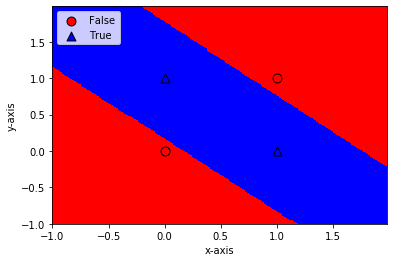

In [7]:
numpy.random.seed(0)
X = numpy.array([[0, 0],
                 [0, 1],
                 [1, 0],
                 [1, 1]])

y = numpy.array([0, 1, 1, 0])

# Inicializando a rede neural com 2 neuronios de entrada, 2 neuronios na camada oculta e 1 neuronio na saida. 
nn = NeuralNetwork([2, 2, 1])
nn.fit(X, y, epochs=10)

print("Predicao final")
for s in X:
    print(s, nn.predict(s))

nn.plot_decision_regions(X, y)

***Inicializando a rede neural com 1 camada de entrada, 2 camadas ocultas e 1 camada de saida.***

Neste exemplo, ([2,4,3,1]) representará uma rede neural de três camadas, com quatro neurônios na primeira camada oculta e três neurônios na segunda camada oculta, e a sua escolha fornecerá a seguinte figura:

Predicao final
[0 0] 0.00026933090141420795
[0 1] 0.9894134677309471
[1 0] 0.981967865426528
[1 1] 0.0005857344542498744


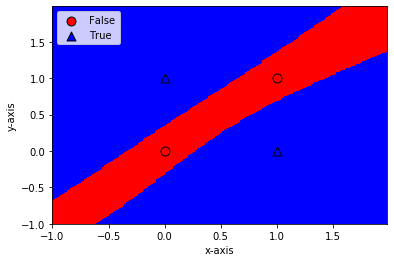

In [10]:
numpy.random.seed(0)
X = numpy.array([[0, 0],
                 [0, 1],
                 [1, 0],
                 [1, 1]])

y = numpy.array([0, 1, 1, 0])

# Inicializando a rede neural com 2 neuronios de entrada, 2 neuronios na camada oculta e 1 neuronio na saida. 
nn = NeuralNetwork([2, 4, 3, 1])
nn.fit(X, y, epochs=10)

print("Predicao final")
for s in X:
    print(s, nn.predict(s))

nn.plot_decision_regions(X, y)

***Inicializando a rede neural com 1 camada de entrada, 1 camada oculta e 1 camada de saida.***

Neste exemplo, vamos definir nossa rede como ([2,4,1])

Predicao final
[0 0] 5.665803375067655e-06
[0 1] 0.9801104327685772
[1 0] 0.9797223435751025
[1 1] 0.00047111636733535776


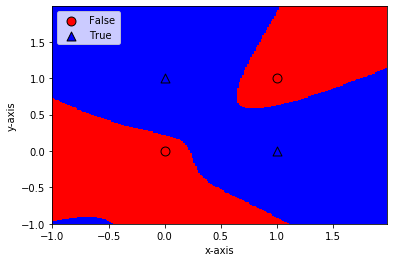

In [11]:
numpy.random.seed(0)
X = numpy.array([[0, 0],
                 [0, 1],
                 [1, 0],
                 [1, 1]])

y = numpy.array([0, 1, 1, 0])

# Inicializando a rede neural com 2 neuronios de entrada, 2 neuronios na camada oculta e 1 neuronio na saida. 
nn = NeuralNetwork([2, 4, 1])
nn.fit(X, y, epochs=10)

print("Predicao final")
for s in X:
    print(s, nn.predict(s))

nn.plot_decision_regions(X, y)

***Conclusão***

Arquiteturas de redes neurais diferentes (por exemplo, implementar uma rede com um número diferente de neurônios na camada oculta ou com mais de apenas uma camada oculta) podem produzir uma região de separação diferente.